<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_01_imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Testing Class Imbalance

1. **Analyze Class Imbalance**:
    - Check the distribution of classes in your target variable.
    - Visualize the imbalance using bar plots or pie charts.

2. **Implement Sampling Techniques**:
    - **Random Undersampling**: Already included in your pipeline.
    - **Random Oversampling**: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique).
    - **Combination of Over- and Undersampling**: Apply methods like SMOTEENN or SMOTETomek.

3. **Evaluate the Impact of Sampling**:
    - Compare model performance metrics (e.g., F1-score, precision, recall) before and after applying sampling techniques.
    - Use cross-validation to ensure robustness of the results.

4. **Parameter Tuning**:
    - Tune hyperparameters for both the sampling techniques and the model itself.
    - Use GridSearchCV or RandomizedSearchCV to find the optimal parameters.

5. **Experiment with Different Models**:
    - Compare the performance of different classifiers (e.g., RandomForest, SVM, XGBoost) on your dataset.
    - Use ensemble methods to potentially improve performance.



1. **Analyze Class Imbalance**:

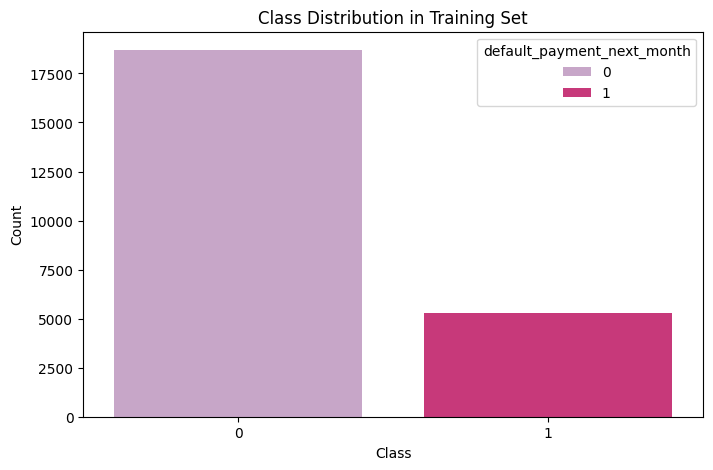

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Plot class balance in the training set
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, hue=y_train, palette='PuRd')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


### 1. Adjusting Class Weights in the Model
You can modify the class weights in the loss function of your neural network. This approach is already somewhat addressed in your code, but you can fine-tune the class weights to see if it improves performance.

### 2. Using Different Thresholds for Classification
Instead of the default threshold of 0.5 for binary classification, you can experiment with different threshold values to find the optimal one that balances precision and recall.

### 3. Resampling Techniques (Undersampling/Oversampling)
You can try undersampling the majority class or oversampling the minority class using techniques like RandomUndersampler or RandomOversampler. This approach is already part of your pipeline, but you can try different sampling strategies.



### Refactor Load and Process Steps

In [13]:
import pandas as pd
import torch
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, define_preprocessor, preprocess_data

def load_and_preprocess_data(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)
    X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    return X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor


## Experiment with Different Class Weights

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score
from model_pipeline import SklearnSimpleNN, train_model, evaluate_model

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = load_and_preprocess_data(url, categorical_columns, target)

# Function to evaluate the model with different class weights
def evaluate_class_weights(class_weights):
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    f1 = f1_score(y_test_tensor.numpy(), y_pred)
    return f1

# Generate a range of class weights to test
class_weight_range = np.linspace(0.5, 5.0, 10)
best_f1 = 0
best_weights = None

for weight in class_weight_range:
    class_weights = [1.0, weight]
    f1 = evaluate_class_weights(class_weights)
    print(f"Class weights: {class_weights}, F1-score: {f1}")
    if f1 > best_f1:
        best_f1 = f1
        best_weights = class_weights

print(f"Best class weights: {best_weights}, Best F1-score: {best_f1}")

# Train and evaluate the model with the best class weights
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_weights[1])
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

Class weights: [1.0, 0.5], F1-score: 0.3651877133105802
Class weights: [1.0, 1.0], F1-score: 0.48958815363257757
Class weights: [1.0, 1.5], F1-score: 0.4928057553956834
Class weights: [1.0, 2.0], F1-score: 0.5168450257629805


In [15]:
print(best_weights)

None


### Testing Different Thresholds

Classification report for threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87      4673
         1.0       0.55      0.50      0.53      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.69      0.70      6000
weighted avg       0.79      0.80      0.80      6000

Classification report for threshold 0.2:

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      4673
         1.0       0.56      0.48      0.52      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.69      0.70      6000
weighted avg       0.79      0.80      0.80      6000

Classification report for threshold 0.30000000000000004:

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      4673
         1.0       0.58      0.47      0.52      1327

    accuracy                           0

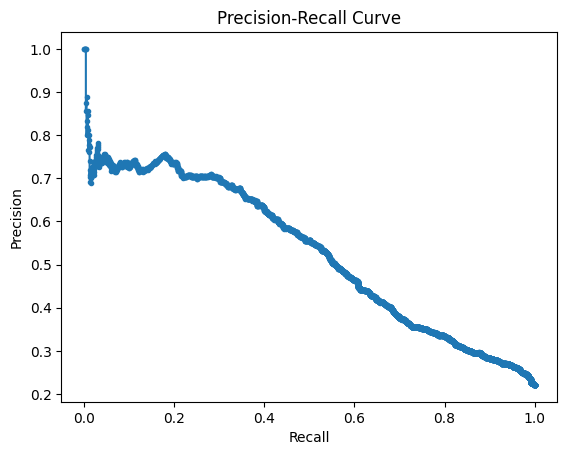

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, define_preprocessor, preprocess_data, SklearnSimpleNN, train_model, evaluate_model
from sklearn.metrics import classification_report, precision_recall_curve

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)
preprocessor = define_preprocessor(X_train)
X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

# Calculate class weights for imbalanced datasets
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the neural network estimator
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])

# Train the model
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

# Predict probabilities on the test set
y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

# Evaluate the model with different thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    print(f"Classification report for threshold {threshold}:\n")
    print(classification_report(y_test_tensor.numpy(), y_pred))

# Plot Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test_tensor.numpy(), y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [6]:
# Manually setting different class weights
class_weights = [1.0, 2.0]  # Example weights for [class 0, class 1]

# Define the neural network estimator with new weights
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])

# Train and evaluate the model
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

NameError: name 'SklearnSimpleNN' is not defined

2. **Implement and Evaluate Sampling Techniques**:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize class distribution
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Set')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Function to apply SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

# Function to apply SMOTEENN
def apply_smoteenn(X_train, y_train):
    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

3. **Evaluate Impact**:

In [ ]:
# Function to evaluate different sampling techniques
def evaluate_sampling_techniques(X_train, X_test, y_train, y_test, preprocessor, class_weights, SklearnSimpleNN, sampling_technique=None):
    if sampling_technique:
        X_train_resampled, y_train_resampled = sampling_technique(X_train, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_resampled, y_train_resampled, X_test, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

4. **Comparison and Visualization**:

In [ ]:
  # Compare results of different sampling techniques
  print("Original Data:")
  evaluate_sampling_techniques(X_train, X_test, y_train, y_test, preprocessor, class_weights, SklearnSimpleNN)

  print("SMOTE:")
  evaluate_sampling_techniques(X_train, X_test, y_train, y_test, preprocessor, class_weights, SklearnSimpleNN, apply_smote)

  print("SMOTEENN:")
  evaluate_sampling_techniques(X_train, X_test, y_train, y_test, preprocessor, class_weights, SklearnSimpleNN, apply_smoteenn)